In [75]:
import numpy as np
import matplotlib.pyplot as plt

#Import existing datasets from sklearn
from sklearn import datasets
from typing import Dict, List


In [76]:
# X - feature value vectors, y - corresponding target label, 200 data points. If no noise, they form clean moons and easy to classify. (not close to real data) 
X, y = datasets.make_moons(200, noise=0.15)
#X.shape (200, 2)
#y.shape (200)

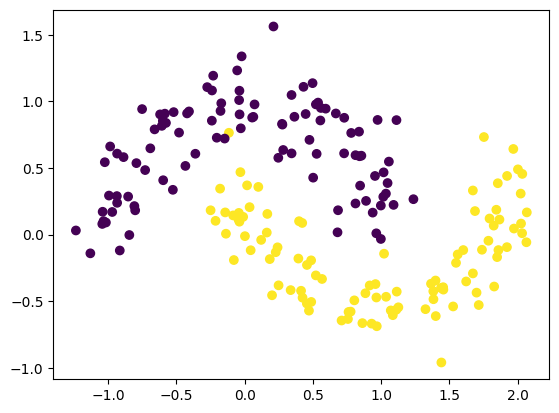

In [77]:
#Visualize the data generated
plt.scatter(X[:,0], X[:,1], c=y)

In [78]:
#Hyperparameters
# 2 features
input_neurons = 2
# 1 if BCE loss and 2 if cross entropy as we use softmax on both. 
output_neurons = 2
samples = X.shape[0]
learning_rate = 0.001
#regularization. Mispelled as to not to override the default lambda functionality in python
lamda = 0.01 

![NN](./7.nn.drawio.png)

In [79]:
#Exactly how a model is represented in pytorch
#model_dict = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

#Weight Retrieval 
def retrieve(model_dict):
    W1 = model_dict['W1']
    b1 = model_dict['b1']
    W2 = model_dict['W2']
    b2 = model_dict['b2']
    return W1, b1, W2, b2


In [80]:
#Forward prop
# ReLU usually used w/ images. For, FFN in this case we can use sigmoid/tanh.
def forward_prop(X, model_dict):
    W1, b1, W2, b2 = retrieve(model_dict)
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)  
    z2 = a1.dot(W2) + b2
    a2 = np.tanh(z2)
    #Now our output layer has 2 neurons and we apply softmax to get probablities 
    exp_scores = np.exp(a2)
    softmax = exp_scores/np.sum(exp_scores, axis=1, keepdims=True) #Sum across the columns for each sample. 
    return z1, a1, softmax

In [81]:
#Loss function: softmax is the prediction returned by the forward_prop and y are the ground truth labels. Here we use cross-entropy .
#Note: Crossentropy calculates the loss only over the correct labels.
def loss(softmax, y, model_dict):
    W1, b1, W2, b2 = retrieve(model_dict)
    m = np.zeros(y.shape[0])
    for i,correct_idx in enumerate(y):
        predicted = softmax[i][correct_idx]
        m[i] = predicted
    log_prob = -np.log(predicted) #log probabilties per sample
    softmax_loss = np.sum(log_prob) # all samples
    reg_loss = (lamda/2) *  (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    loss = softmax_loss + reg_loss
    return float(loss/y.shape[0])


In [82]:
#Prediction - similar to forward prop. Just return the argmax instead of softmax
def predict(X, model_dict):
    W1, b1, W2, b2 = retrieve(model_dict)
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)  
    z2 = a1.dot(W2) + b2
    a2 = np.tanh(z2)
    #Now our output layer has 2 neurons and we apply softmax to get probablities 
    exp_scores = np.exp(a2)
    softmax = exp_scores/np.sum(exp_scores, axis=1, keepdims=True) #Sum across the columns for each sample. 
    return np.argmax(softmax, axis = 1) #200,2 matrix. Need max ACROSS the columns so dim=1. argmax returns the index where the maximum value is. 

In [83]:
#Back Propagation
def backpropagation(X, y, model_dict, epochs):
    for i in range(epochs):
        W1, b1, W2, b2 = retrieve(model_dict)
        z1, a1, probs = forward_prop(X, model_dict)
        #To avoid overwriting probs when updating delta3. We need probs when calculating loss later
        delta3 = np.copy(probs) 
        
        delta3[range(y.shape[0]), y] -= 1 #200,2 matrix, pick the values given by label in y for each sample
        dW2 = (a1.T).dot(delta3) #ai: 200, 3 delta3: 200, 2 --> (3,2)
        db2 = np.sum(delta3, axis=0, keepdims=True) # delta3 200,2 -> (1,2)
        
        delta2 = (delta3.dot(W2.T)) * (1-np.power(np.tanh(z1), 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0) 

        #Add regularization
        dW2 += lamda*np.sum(W2)
        dW1 += lamda*np.sum(W1)

        #update the weights and biases
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

        #Update model dict
        model_dict = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        #Print Loss every 50 epochs
        if i%50 == 0:
            print(f"Loss at epoch {i} is: {loss(probs,y,model_dict):.3f}")
    
    return model_dict

In [84]:
#init weights - Xavier initialization
def init_network(input_dim, hidden_dim, output_dim):
    #initialize the model
    model = {}
    W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
    b1 = np.zeros((1, hidden_dim)) #usually biases are initialized to zeros
    W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
    b2 = np.zeros((1, output_dim))

    model['W1'] = W1
    model['b1'] = b1
    model['W2'] = W2
    model['b2'] = b2

    return model

In [85]:
#Define model and train
model_dict = init_network(input_dim=input_neurons, hidden_dim=3, output_dim=output_neurons)

#trained model. Epochs 1500. Can chose any number. 
model = backpropagation(X=X, y=y, model_dict=model_dict, epochs=1500)

Loss at epoch 0 is: 0.001
Loss at epoch 50 is: 0.001
Loss at epoch 100 is: 0.001
Loss at epoch 150 is: 0.001
Loss at epoch 200 is: 0.002
Loss at epoch 250 is: 0.002
Loss at epoch 300 is: 0.003
Loss at epoch 350 is: 0.003
Loss at epoch 400 is: 0.004
Loss at epoch 450 is: 0.004
Loss at epoch 500 is: 0.005
Loss at epoch 550 is: 0.006
Loss at epoch 600 is: 0.007
Loss at epoch 650 is: 0.008
Loss at epoch 700 is: 0.009
Loss at epoch 750 is: 0.011
Loss at epoch 800 is: 0.012
Loss at epoch 850 is: 0.014
Loss at epoch 900 is: 0.016
Loss at epoch 950 is: 0.017
Loss at epoch 1000 is: 0.019
Loss at epoch 1050 is: 0.021
Loss at epoch 1100 is: 0.023
Loss at epoch 1150 is: 0.026
Loss at epoch 1200 is: 0.028
Loss at epoch 1250 is: 0.031
Loss at epoch 1300 is: 0.033
Loss at epoch 1350 is: 0.036
Loss at epoch 1400 is: 0.039
Loss at epoch 1450 is: 0.042
